In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import os.path as osp

# Set the number of (emulated) host devices
num_devices = 4
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={num_devices}"

import numpy as np

import jax
import jax.numpy as jnp
from jax import lax
import gymnax

jax.device_count(), jax.devices()

(4, [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)])

In [3]:
from utils.models import get_model_ready
from utils.helpers import load_config, save_pkl_object
from src.control.dynamics import cartpole_step,CartPoleEnvState,cartpole_kinematics

"""Run training with ES or PPO. Store logs and agent ckpt."""
ppo_yaml = osp.join("expert_agents","CartPole-v1","ppo.yaml")
seed_id = 123
lrate = 5e-04

config = load_config(ppo_yaml, seed_id, lrate)

rng = jax.random.PRNGKey(config.train_config.seed_id)
# Setup the model architecture
rng, rng_init = jax.random.split(rng)
model, policy_params = get_model_ready(rng_init, config.train_config)

In [4]:
def batch_step(x,x_dot,theta,theta_dot, action):
    return jax.vmap(cartpole_step, in_axes=(0, 0,0,0,0))(
        x,x_dot,theta,theta_dot, action)
    

In [5]:
state = CartPoleEnvState(jnp.array([0.1]),jnp.array([0.1]),jnp.array([0.1]),jnp.array([0.1]))
action = jnp.array([0])

In [6]:
state = cartpole_step(state.x,state.x_dot,state.theta,state.theta_dot,action)
state

Array([[ 0.102     ],
       [-0.09640235],
       [ 0.102     ],
       [ 0.42248276]], dtype=float64)

In [7]:
state_batch = CartPoleEnvState(jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)))
action_batch = jnp.array(np.random.randint(0,2,5))

In [8]:
state_batch

CartPoleEnvState(x=Array([-0.49284032,  1.02885845,  0.13516916, -1.46686507, -1.24444466],      dtype=float64), x_dot=Array([-0.45490259, -0.20235229,  0.0206057 , -0.79787932, -0.23931117],      dtype=float64), theta=Array([ 0.57999837,  2.63459132, -0.44573734,  0.57568943, -0.38591262],      dtype=float64), theta_dot=Array([ 0.43615069, -2.16858843,  0.54762725,  0.14619197, -0.16265067],      dtype=float64))

In [9]:
next_state  = batch_step(
  state_batch.x,state_batch.x_dot,state_batch.theta,state_batch.theta_dot, action_batch
)

In [10]:
next_state

Array([[-0.50193837, -0.65216214,  0.58872138,  0.84476997],
       [ 1.0248114 , -0.38599085,  2.59121955, -2.26664086],
       [ 0.13558127,  0.21848911, -0.4347848 ,  0.15305377],
       [-1.48282266, -0.99525862,  0.57861327,  0.55459717],
       [-1.24923088, -0.42749082, -0.38916564, -0.01180364]],      dtype=float64)

In [11]:
# Jit-Compiled Episode Rollout
from functools import partial

jit_rollout = jax.jit(partial(cartpole_kinematics,cartpole_step=cartpole_step))

In [12]:
state = CartPoleEnvState(jnp.array([0.1]),jnp.array([0.1]),jnp.array([0.1]),jnp.array([0.1]))
action = jnp.array(np.random.randint(0,2,10))

In [13]:
x_rollout, x_dot_rollout, theta_rollout, theta_dot_rollout = jit_rollout(state.x,state.x_dot,state.theta,state.theta_dot,action)

In [14]:
x_rollout

Array([[0.102     ],
       [0.10007195],
       [0.10201471],
       [0.1078251 ],
       [0.11750197],
       [0.12324842],
       [0.13286433],
       [0.14635   ],
       [0.15590839],
       [0.16934194]], dtype=float64)

## Expert Demo

In [15]:
from utils.models import load_neural_network
from gymnax.visualize import Visualizer


In [16]:
base =  osp.join("expert_agents","CartPole-v1","ppo")
configs = load_config(base + ".yaml")
model, model_params = load_neural_network(
    configs.train_config, base + ".pkl"
)

Loaded data from expert_agents\CartPole-v1\ppo.pkl.


In [17]:
def rollout_episode(env, env_params, model, model_params, max_frames=200):
    state_seq = []
    rng = jax.random.PRNGKey(0)

    rng, rng_reset = jax.random.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)

    if model is not None:
        if model.model_name == "LSTM":
            hidden = model.initialize_carry()

    t_counter = 0
    reward_seq = []
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)

        v, pi = model.apply(model_params, obs, rng_act)

        action = pi.sample(seed=rng_act)

        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state, action, env_params
        )
      
        reward_seq.append(reward)
        print(t_counter, reward, action, done)
        print(10 * "=")
        t_counter += 1
        if t_counter == max_frames:
            break
        else:
            env_state = next_env_state
            obs = next_obs
    print(f"{env.name} - Steps: {t_counter}, Return: {np.sum(reward_seq)}")
    return state_seq, np.cumsum(reward_seq)

In [18]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)
state_seq, cum_rewards = rollout_episode(
    env, env_params, model, model_params
)

0 1.0 1 False
1 1.0 1 False
2 1.0 0 False
3 1.0 1 False
4 1.0 0 False
5 1.0 1 False
6 1.0 0 False
7 1.0 0 False
8 1.0 0 False
9 1.0 1 False
10 1.0 0 False
11 1.0 1 False
12 1.0 0 False
13 1.0 1 False
14 1.0 0 False
15 1.0 1 False
16 1.0 0 False
17 1.0 1 False
18 1.0 0 False
19 1.0 1 False
20 1.0 0 False
21 1.0 1 False
22 1.0 0 False
23 1.0 1 False
24 1.0 0 False
25 1.0 1 False
26 1.0 0 False
27 1.0 0 False
28 1.0 1 False
29 1.0 1 False
30 1.0 1 False
31 1.0 0 False
32 1.0 0 False
33 1.0 1 False
34 1.0 0 False
35 1.0 1 False
36 1.0 0 False
37 1.0 1 False
38 1.0 1 False
39 1.0 0 False
40 1.0 0 False
41 1.0 1 False
42 1.0 0 False
43 1.0 1 False
44 1.0 0 False
45 1.0 1 False
46 1.0 0 False
47 1.0 1 False
48 1.0 1 False
49 1.0 0 False
50 1.0 0 False
51 1.0 1 False
52 1.0 1 False
53 1.0 0 False
54 1.0 1 False
55 1.0 0 False
56 1.0 1 False
57 1.0 1 False
58 1.0 0 False
59 1.0 1 False
60 1.0 0 False
61 1.0 1 False
62 1.0 0 False
63 1.0 0 False
64 1.0 1 False
65 1.0 0 False
66 1.0 0 False
67 1.

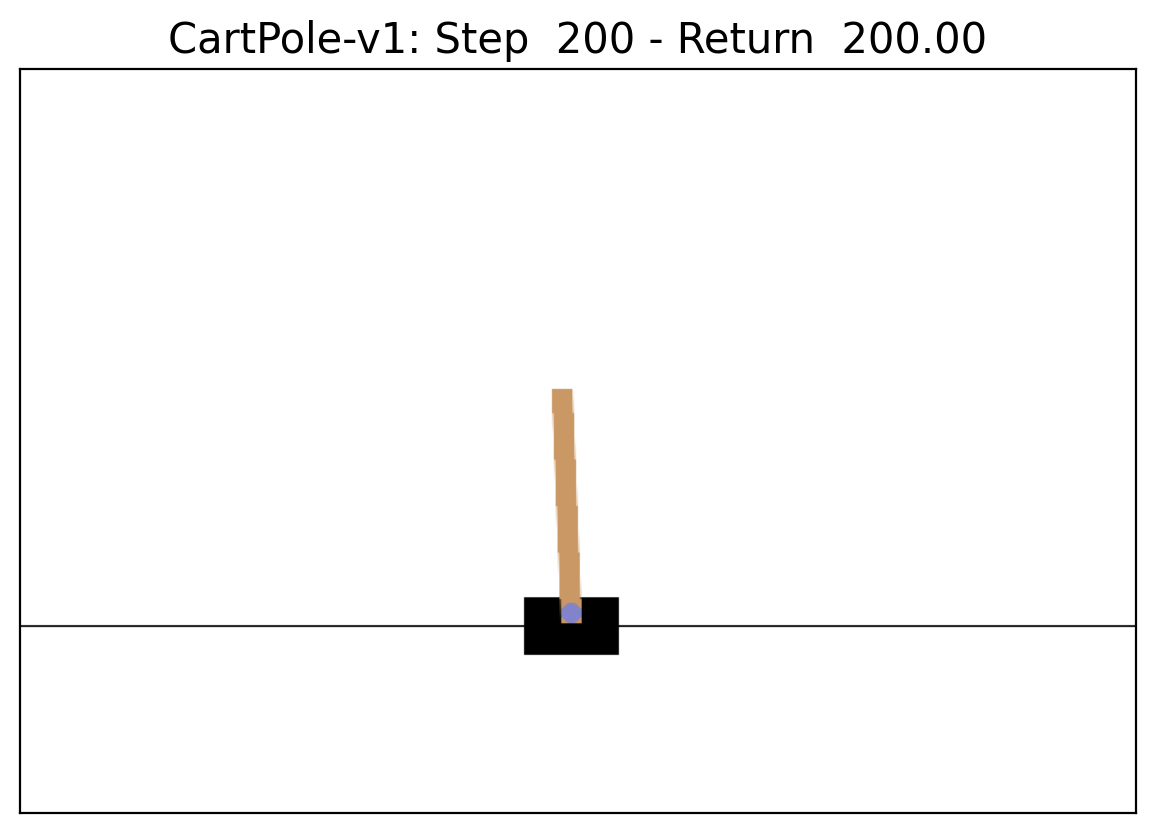

In [19]:
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate(osp.join("results","CartPole-v1.gif"))